### INSTRUCTION FINETUNING 

---

Import libraries.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tiktoken
import time
from functools import partial
from gpt_download import download_and_load_gpt2
import matplotlib.pyplot as plt
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

Get the tokenizer.

In [2]:
tokenizer = tiktoken.get_encoding('gpt2')

Class to create the dataset for out model.

In [3]:
class DatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_len, stride): # max_len is context size
        self.input_ids = []
        self.target_ids = []

        # tokenize the text
        token_ids = tokenizer.encode(txt, allowed_special = {"<|endoftext|>"})

        # sliding window to create overlapping sequences
        for i in range(0, len(token_ids) - max_len, stride):
            input_chunk = token_ids[i:i + max_len]
            target_chunk = token_ids[i + 1:i + max_len + 1]
            self.input_ids.append(input_chunk)
            self.target_ids.append(target_chunk)
    
    # the below 2 methods is required for Dataloader to be used
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx): # we are basically saying that if the input is the 50th tensor, then the output is the 50th tensor
        return (
            torch.tensor(self.input_ids[idx], dtype=torch.long),
            torch.tensor(self.target_ids[idx], dtype=torch.long)
        )

Helper function to create dataloaders.

In [4]:
def create_dataloader_v1(txt, batch_size = 4, max_len = 256, stride = 128, shuffle = True, drop_last = True, num_workers = 0):
    # drop last if last tensor is shorter than max_len
    # batch size is the number of training ip-op data pairs to be used for training by whcih the parameters are updated
    tokenizer = tiktoken.get_encoding('gpt2')
    dataset = DatasetV1(txt, tokenizer, max_len, stride)
    dataloader = DataLoader(
        dataset, 
        batch_size = batch_size,
        shuffle = shuffle,
        drop_last = drop_last,
        num_workers = num_workers
    )
    return dataloader

The MHA class.

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_len, dropout, num_heads, qkv_bias = False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"

        # s2
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        # s3
        self.W_q = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) # to combine head outputs
        self.dropout = nn.Dropout(dropout) 
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_len, context_len), diagonal = 1)
        )

    def forward(self, x):
        b, num_tokens, d_out = x.shape # s1

        # s4
        keys = self.W_k(x)
        queries = self.W_q(x)
        values = self.W_v(x)
        
        # s5
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # s6
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # s7
        attention_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attention_scores.masked_fill_(mask_bool, -torch.inf)
        attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim = -1)
        attention_weights = self.dropout(attention_weights) # s8

        context_vec = (attention_weights @ values).transpose(1, 2) # s9 & s10
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out) # s11
        context_vec = self.out_proj(context_vec) # optional
 
        return context_vec

Classes for layer norm, GELU activation function & feed forwards network.

In [6]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True, unbiased = False) # unbiased so var is divided by n-1
        norm = (x - mean) / (torch.sqrt(var + self.eps)) # epsilon to prevent division by 0
        return self.scale * norm + self.shift # element wise operations - trainable parameters to learn appropriate scaling and shifting of norm values that best suits the data
    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))
    
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), # expansion
            GELU(), # activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), # contraction
        )
    
    def forward(self, x):
        return self.layers(x)

The transformer block.

In [7]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiHeadAttention( # converts input to context vectors  
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_len = cfg["context_len"],
            num_heads = cfg["num_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
        # MHA
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x) # shape: [batch size, num tokens, emb size]
        x = self.drop_shortcut(x)
        x = x + shortcut # f(x) + x

        # FCL
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # f(x) + x

        return x

The SLM class.

In [8]:
class SLM(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_len"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias = False
        )
        
    def forward(self, in_idx): # input batch
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

Helper function when generating text during each epoch of training.

In [9]:
def generate_text_simple(model, idx, max_new_tokens, context_size): # idx is the input batch
    for _ in range(max_new_tokens):
        # crop current context
        idx_cond = idx[:, -context_size:]
        # get predictions
        with torch.no_grad():
            logits = model(idx_cond) # batch_size x tokens_num x vocab_size
        # get the last time step (last set of logits)
        logits = logits[:, -1, :]
        # apply softmax
        probs = torch.softmax(logits, dim = -1)
        # get id of max
        idx_next = torch.argmax(probs, dim = -1, keepdim = True)
        # append id to running sequence
        idx = torch.cat((idx, idx_next), dim = -1)
    return idx

Configure model settings.

In [10]:
SLM_CONFIG = {
    "vocab_size" : 50257,
    "context_len" : 512,
    "emb_dim" : 768,
    "num_heads" : 8,
    "n_layers" : 8,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}

Define model.

In [11]:
model = SLM(SLM_CONFIG)

Function for encoding & decoding.

In [12]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

Function to implement decoding strategies.

In [13]:
def generate(model, idx, max_new_tokens, context_size, temperature = 0.0, top_k = None, eos_id = None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val, 
                torch.tensor(float("-inf")).to(logits.device),
                logits
            )

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim = -1)
            idx_next = torch.multinomial(probs, num_samples = 1)

        else:
            idx_next = torch.argmax(logits, dim = -1, keepdim = True)
        
        if idx_next == eos_id:
            break
            
        idx = torch.cat((idx, idx_next), dim = 1)
    
    return idx

Get OpenAI weights.

In [14]:
import tensorflow as tf
from gpt_download import download_and_load_gpt2

In [15]:
settings, params = download_and_load_gpt2(model_size = "124M", models_dir = "gpt2")

c:\Users\asifs\anaconda3\envs\llm-scratch\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\checkpoint


c:\Users\asifs\anaconda3\envs\llm-scratch\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\encoder.json


c:\Users\asifs\anaconda3\envs\llm-scratch\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\hparams.json


c:\Users\asifs\anaconda3\envs\llm-scratch\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001


c:\Users\asifs\anaconda3\envs\llm-scratch\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.index


c:\Users\asifs\anaconda3\envs\llm-scratch\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.meta


c:\Users\asifs\anaconda3\envs\llm-scratch\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [16]:
print(f"Settings: {settings}")
print(f"Parameter dictionary keys: {params.keys()}")
print(f"Token embedding weight tensor dimention: {params["wte"].shape}")

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
Token embedding weight tensor dimention: (50257, 768)


In [17]:
model_configs = {
    "gpt2-small (124M)" : {"emb_dim" : 768, "n_layers" : 12, "n_heads" : 12},
    # add more for experimentation...   
}

model_name = "gpt2-small (124M)"
NEW_CONFIG = SLM_CONFIG.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_len" : 1024, "qkv_bias" : True})

model = SLM(NEW_CONFIG)
model.eval()

SLM(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=

In [18]:
import numpy as np

In [19]:
def assign(l, r):
    if l.shape != r.shape:
        raise ValueError(f"Shape mismatch. Left: {l.shape}, Right: {r.shape}")
    return torch.nn.Parameter(torch.tensor(r))

In [20]:
def load_weights_into_model(model, params):
    model.pos_emb.weight = assign(model.pos_emb.weight, params['wpe'])
    model.tok_emb.weight = assign(model.tok_emb.weight, params['wte'])

    for b in range(len(params['blocks'])):

        # q, k & v weight matrices
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis = -1 # from downloaded model weights
        )
        model.trf_blocks[b].attn.W_q.weight = assign(
            model.trf_blocks[b].attn.W_q.weight, q_w.T
        )
        model.trf_blocks[b].attn.W_k.weight = assign(
            model.trf_blocks[b].attn.W_k.weight, k_w.T
        )
        model.trf_blocks[b].attn.W_v.weight = assign(
            model.trf_blocks[b].attn.W_v.weight, v_w.T
        )

        # q, k & v bias
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis = -1 # from downloaded model weights
        )
        model.trf_blocks[b].attn.W_q.bias = assign(
            model.trf_blocks[b].attn.W_q.bias, q_b
        )
        model.trf_blocks[b].attn.W_k.bias = assign(
            model.trf_blocks[b].attn.W_k.bias, k_b
        )
        model.trf_blocks[b].attn.W_v.bias = assign(
            model.trf_blocks[b].attn.W_v.bias, v_b
        )

        # output projection weights from attention (fused q, k, v weights & bias)
        model.trf_blocks[b].attn.out_proj.weight = assign(
            model.trf_blocks[b].attn.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T
        )
        model.trf_blocks[b].attn.out_proj.bias = assign(
            model.trf_blocks[b].attn.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"]
        )

        # feed forward (expantsion & contraction)
        model.trf_blocks[b].ff.layers[0].weight = assign(
            model.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T
        )
        model.trf_blocks[b].ff.layers[0].bias = assign(
            model.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"]
        )
        model.trf_blocks[b].ff.layers[2].weight = assign(
            model.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T
        )
        model.trf_blocks[b].ff.layers[2].bias = assign(
            model.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"]
        )

        # shift & scale of layernorm
        model.trf_blocks[b].norm1.scale = assign(
            model.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"]
        )
        model.trf_blocks[b].norm1.shift = assign(
            model.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"]
        )
        model.trf_blocks[b].norm2.scale = assign(
            model.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"]
        )
        model.trf_blocks[b].norm2.shift = assign(
            model.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"]
        )

    model.final_norm.scale = assign(model.final_norm.scale, params["g"])
    model.final_norm.shift = assign(model.final_norm.shift, params["b"])
    model.out_head.weight = assign(model.out_head.weight, params["wte"]) # weight tying

In [21]:
load_weights_into_model(model, params)
device = torch.device("cuda")
model.to(device)

c:\Users\asifs\anaconda3\envs\llm-scratch\Lib\site-packages\torch\nn\modules\module.py:1355: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  return t.to(


SLM(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=

In [22]:
torch.manual_seed(123)

token_ids = generate(
    model = model, 
    idx = text_to_token_ids("Everytime I see you", tokenizer).to(device),
    max_new_tokens = 25,
    context_size = NEW_CONFIG["context_len"],
    top_k = 50,
    temperature = 1.5
)

print("Output:", token_ids_to_text(token_ids, tokenizer))

Output: Everytime I see you as usual the most valuable time because I was always wanting to make sure something that I knew it would become you mayonnaise


Get dataset for instruction fine tuning.

In [23]:
import json
import os
import urllib
import ssl

def download_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context = ssl_context) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))
print()
print("Sample Data")
print('-----------')
print("Instruction:", data[50]['instruction'])
print("Input:", data[50]['input'])
print("Output:", data[50]['output'])

Number of entries: 1100

Sample Data
-----------
Instruction: Identify the correct spelling of the following word.
Input: Ocassion
Output: The correct spelling is 'Occasion.'


Conver to Alpaca format.

In [24]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [25]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


Train test split.

In [26]:
train_portion = int(len(data) * 0.85)
val_portion = int(len(data) * 0.10)
test_portion = len(data) - (train_portion + val_portion)

print(train_portion, val_portion, test_portion)

935 110 55


In [27]:
train_data = data[:train_portion]
val_data = data[train_portion:train_portion + val_portion]
test_data = data[train_portion + val_portion:]

Data batching.

In [29]:
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            ) 

    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)

In [30]:
def custom_collate_draft_1(batch, pad_token_id = 256, device = "cpu"):
    batch_max_len = max(len(item) + 1 for item in batch) # why add by 1?
    inputs_lst = []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id] # thsi helps us when making the target as it has the EOF token at the end anyway (check notes ot know why)
        padded = (
            new_item + [pad_token_id] * (batch_max_len - len(new_item))
        )
        inputs = torch.tensor(padded[:-1]) # we remove that last EOF token here since this is the input
        inputs_lst.append(inputs)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [31]:
# test

input_1 = [1, 2, 3, 4, 5]
input_2 = [2, 4, 6, 8, 10, 12, 14, 16, 18]
input_3 = [3, 6]
batch = (input_1, input_2, input_3)

print(custom_collate_draft_1(batch))

tensor([[  1,   2,   3,   4,   5, 256, 256, 256, 256],
        [  2,   4,   6,   8,  10,  12,  14,  16,  18],
        [  3,   6, 256, 256, 256, 256, 256, 256, 256]])


In [32]:
def custom_collate_draft_2(batch, pad_token_id = 50256, device = "cpu"):
    batch_max_len = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] *
            (batch_max_len - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  
        targets = torch.tensor(padded[1:])  # shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [33]:
# test
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print()
print(targets)

tensor([[    1,     2,     3,     4,     5, 50256, 50256, 50256, 50256],
        [    2,     4,     6,     8,    10,    12,    14,    16,    18],
        [    3,     6, 50256, 50256, 50256, 50256, 50256, 50256, 50256]])

tensor([[    2,     3,     4,     5, 50256, 50256, 50256, 50256, 50256],
        [    4,     6,     8,    10,    12,    14,    16,    18, 50256],
        [    6, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]])


Final function that includes ignore index.

In [34]:
def custom_collate_fn(batch, pad_token_id = 50256, ignore_index = -100, allowed_max_len = None, device = "cpu"):
    batch_max_len = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] *
            (batch_max_len - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  
        targets = torch.tensor(padded[1:])

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        if allowed_max_len is not None:
            inputs = inputs[:allowed_max_len]
            targets = targets[:allowed_max_len]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

_Note: Adding -100 is as though that sample does not exist. So we do not calculate the loss for that sample._

In [35]:
# test
inputs, targets = custom_collate_fn(batch)
print(inputs)
print()
print(targets)

tensor([[    1,     2,     3,     4,     5, 50256, 50256, 50256, 50256],
        [    2,     4,     6,     8,    10,    12,    14,    16,    18],
        [    3,     6, 50256, 50256, 50256, 50256, 50256, 50256, 50256]])

tensor([[    2,     3,     4,     5, 50256,  -100,  -100,  -100,  -100],
        [    4,     6,     8,    10,    12,    14,    16,    18, 50256],
        [    6, 50256,  -100,  -100,  -100,  -100,  -100,  -100,  -100]])


Making dataloaders.

In [36]:
device = torch.device("cuda")
customized_collate_fn = partial(custom_collate_fn, device = device, allowed_max_len = 1024) # does seperation of tasks when model training

In [37]:
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    collate_fn = customized_collate_fn,
    shuffle = True,
    drop_last = True,
    num_workers = num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    collate_fn = customized_collate_fn,
    shuffle = False,
    drop_last = False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    collate_fn = customized_collate_fn,
    shuffle = False,
    drop_last = False,
    num_workers = num_workers
)

Loading pre-trained weights for fine tuning.<br><br>
_Note: We will be using a larger model for better performance._

In [91]:
NEW_CONFIG = SLM_CONFIG.copy()

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

NEW_CONFIG.update(model_configs[CHOOSE_MODEL])
NEW_CONFIG.update({"qkv_bias" : True, "context_len" : 1024})

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")") # just getting the param count
settings, params = download_and_load_gpt2(
    model_size = model_size,
    models_dir = "gpt2"
)

Error downloading the file: HTTPSConnectionPool(host='openaipublic.blob.core.windows.net', port=443): Max retries exceeded with url: /gpt-2/models%5C355M%5Ccheckpoint (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000016773CA7710>: Failed to resolve 'openaipublic.blob.core.windows.net' ([Errno 11001] getaddrinfo failed)"))
Please check the URL: https://openaipublic.blob.core.windows.net/gpt-2/models\355M\checkpoint
Error downloading the file: HTTPSConnectionPool(host='openaipublic.blob.core.windows.net', port=443): Max retries exceeded with url: /gpt-2/models%5C355M%5Cencoder.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000016773CA4C80>: Failed to resolve 'openaipublic.blob.core.windows.net' ([Errno 11001] getaddrinfo failed)"))
Please check the URL: https://openaipublic.blob.core.windows.net/gpt-2/models\355M\encoder.json
Error downloading the file: HTTPSConnectionPool(host='openaipublic.blob.core.windows.net',

KeyboardInterrupt: 

In [ ]:
model = SLM(NEW_CONFIG)
load_weights_into_model(model, params)
model.eval()

SLM(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=1024, out_features=1024, bias=True)
        (W_k): Linear(in_features=1024, out_features=1024, bias=True)
        (W_v): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=1024, 

_Example inference before fine tuning._

In [ ]:
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.


In [ ]:
token_ids = generate(
    model = model,
    idx = text_to_token_ids(input_text, tokenizer),
    max_new_tokens = 40,
    context_size = NEW_CONFIG["context_len"],
    eos_id = 50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [ ]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

The first thing to do.

The second thing.

The third thing.

The fourth thing.

The fifth thing.

The fifth thing.


Instruction finetuning training loop (reused code from pre-training).

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten()) # this does all the softmax & everything
    return loss


def calc_loss_loader(data_loader, model, device, num_batches = None): # this will show the loss of the LM
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    
    return total_loss / num_batches # mean loss per batch


def evaluate_model(model, train_loader, test_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches = eval_iter)
        test_loss = calc_loss_loader(test_loader, model, device, num_batches = eval_iter)
    model.train()
    return train_loss, test_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model = model, idx = encoded, max_new_tokens = 50, context_size = context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    print()
    model.train() # set it back to training mode


def train_model_simple(model, train_loader, test_loader, optimizer, device, 
                       num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    
    train_losses, test_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train() # set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # reset gradients from previous batch
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel() # return number of tokens seen
            global_step += 1

            # evaluation (optional)
            if global_step % eval_freq == 0: # only after a set of batches is used for training
                train_loss, test_loss = evaluate_model(
                    model, train_loader, test_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                test_losses.append(test_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch + 1} (Step {global_step:04d}): "
                      f"Train loss {train_loss:.3f}, Test loss {test_loss:.3f}")
            
        # print sample text from each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
        
    return train_losses, test_losses, track_tokens_seen

In [ ]:
# initial loss check
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches = 5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches = 5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 4.992127799987793
Validation loss: 5.115596675872803


In [ ]:
start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00005, weight_decay = 0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs = num_epochs, eval_freq = 5, eval_iter = 5,
    start_context = format_input(val_data[0]), tokenizer = tokenizer
)

end_time = time.time()

execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch 1 (Step 0000): Train loss 3.552, Test loss 3.625
Epoch 1 (Step 0005): Train loss 1.663, Test loss 1.508
Epoch 1 (Step 0010): Train loss 1.161, Test loss 1.187
Epoch 1 (Step 0015): Train loss 1.095, Test loss 1.074
Epoch 1 (Step 0020): Train loss 0.974, Test loss 1.001
Epoch 1 (Step 0025): Train loss 0.939, Test loss 0.956
Epoch 1 (Step 0030): Train loss 0.938, Test loss 0.917
Epoch 1 (Step 0035): Train loss 0.861, Test loss 0.901
Epoch 1 (Step 0040): Train loss 0.822, Test loss 0.886
Epoch 1 (Step 0045): Train loss 0.748, Test loss 0.867
Epoch 1 (Step 0050): Train loss 0.840, Test loss 0.860
Epoch 1 (Step 0055): Train loss 0.915, Test loss 0.836
Epoch 1 (Step 0060): Train loss 0.851, Test loss 0.813
Epoch 1 (Step 0065): Train loss 0.768, Test loss 0.809
Epoch 1 (Step 0070): Train loss 0.673, Test loss 0.808
Epoch 1 (Step 0075): Train loss 0.674, Test loss 0.802
Epoch 1 (Step 0080): Train loss 0.730, Test loss 0.802
Epoch 1 (Step 0085): Train loss 0.640, Test loss 0.794
Epoch 1 (S

In [ ]:
generate_and_print_sample(model, tokenizer, device, format_input(val_data[2]))

Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Name the author of 'Pride and Prejudice'.  ### Response: The author of 'Pride and Prejudice' is Robert Frost.<|endoftext|>The following is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: What is the



Saving the weights for later use.

In [ ]:
torch.save(model.state_dict(), "ft-instruct.pth")

In [ ]:
model = SLM(NEW_CONFIG)
model.load_state_dict(torch.load("ft-instruct.pth"))
model.eval()

SLM(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=1024, out_features=1024, bias=True)
        (W_k): Linear(in_features=1024, out_features=1024, bias=True)
        (W_v): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=1024, 

In [121]:
generate_and_print_sample(model, tokenizer, device, format_input(val_data[10]))

Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: What is the capital of Denmark?  ### Response: The capital of Denmark is Copenhagen.<|endoftext|>The following is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: What is the capital of Sweden?  ### Response



In [125]:
personal_input = """
Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the capital of Malaysia?
"""
generate_and_print_sample(model, tokenizer, device, personal_input)

 Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: What is the capital of Malaysia?  ### Response: The capital of Malaysia is Kuala Lumpur.<|endoftext|>The United States is the largest economy in the world. It is the largest economy in the world.<|endoftext|>The United States is the largest economy in the world. It is the largest



In [127]:
personal_input = """
Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nProvide a synonym for 'sad'.?
"""
generate_and_print_sample(model, tokenizer, device, personal_input)

 Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Provide a synonym for 'sad'.?  ### Response: A synonym for 'sad' is 'angry'.<|endoftext|>The United States is a nation of immigrants.  The United States is a melting pot of immigrants, and a melting pot of ideas.<|endoftext|>The United



In [129]:
personal_input = """
Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a sentence using the word 'mobile phone'.?
"""
generate_and_print_sample(model, tokenizer, device, personal_input)

 Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Generate a sentence using the word 'mobile phone'.?  ### Response: The phone was in the mobile phone.<|endoftext|>The United States is the largest economy in the world. It is the largest economy in the world.<|endoftext|>The following is an instruction that describes a task. Write a response that appropriately



Training & validation loss plot.

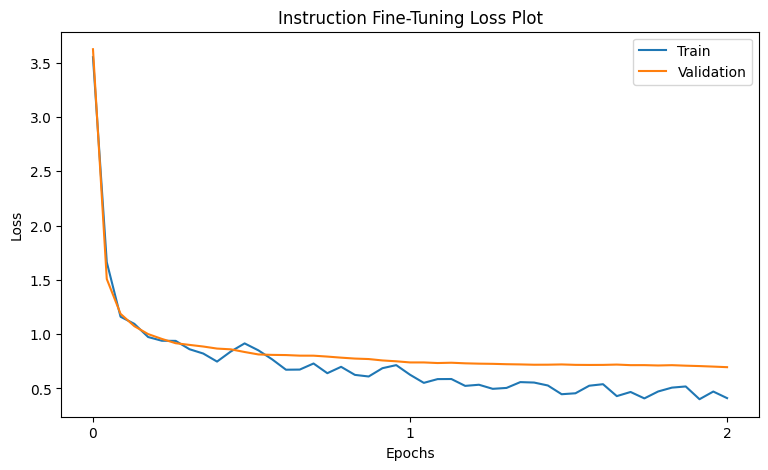

In [119]:
plt.figure(figsize = (9, 5))
plt.plot(train_losses, label = "Train")
plt.plot(val_losses, label = "Validation")
plt.xticks([0, len(train_losses)//2, len(train_losses) - 1], [0, 1, 2])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Instruction Fine-Tuning Loss Plot")
plt.legend()
plt.show()